# Fast tokenizers in the QA pipeline

We will now dive into the `question-answering` pipeline and see how to leverage the offsets to grab the answer to the question at hand from the context, a bit like we did for the grouped entities in the previous section. Then we will see how we can deal with very long contexts that end up being truncated. You can skip this section if you’re not interested in the question answering task.



## 1. Using the question-answering pipeline

In [1]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5.
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading weights:   0%|          | 0/102 [00:00<?, ?it/s]

{'score': 0.9804228237626376,
 'start': 78,
 'end': 106,
 'answer': 'Jax, PyTorch, and TensorFlow'}

Unlike the other pipelines, which can’t truncate and split texts that are longer than the maximum length accepted by the model (and thus may miss information at the end of a document), this pipeline can deal with very long contexts and will return the answer to the question even if it’s at the end:



In [2]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9717117232030432,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

Let’s see how it does all of this!



## 1. Using a model for question answering


Like with any other pipeline, we start by tokenizing our input and then send it through the model. The checkpoint used by default for the question-answering pipeline is `distilbert-base-cased-distilled-squad` (the “squad” in the name comes from the dataset on which the model was fine-tuned)

In [6]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

inputs = tokenizer(text=question, text_pair=context, return_tensors='pt')
outputs = model(**inputs)

Loading weights:   0%|          | 0/102 [00:00<?, ?it/s]

Note that we tokenize the question and the context as a pair, with the question first.



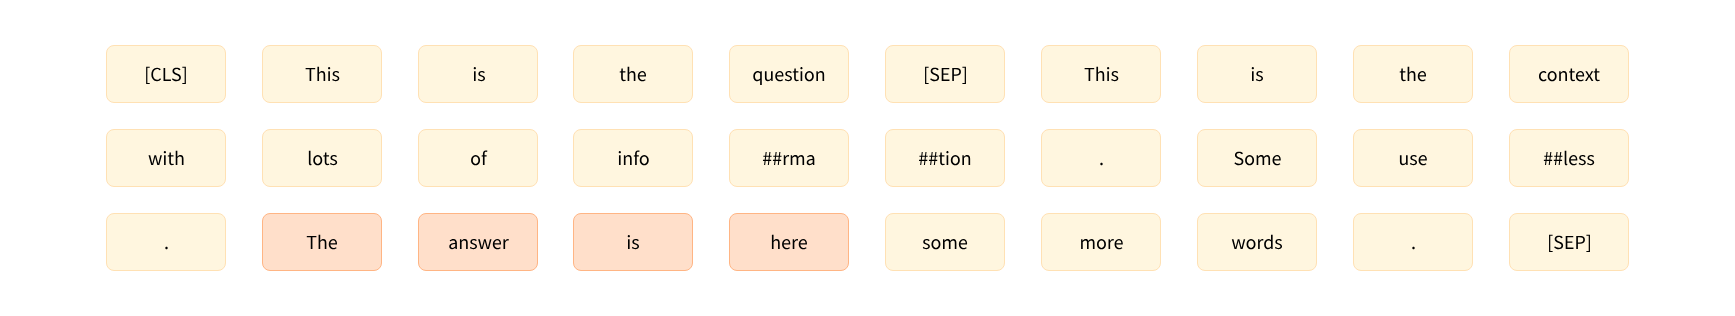

The model has been trained to predict the index of the token starting the answer (here 21) and the index of the token where the answer ends (here 24). This is why those models don’t return one tensor of logits but two: one for the logits corresponding to the start token of the answer, and one for the logits corresponding to the end token of the answer. 

In [7]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([1, 67]) torch.Size([1, 67])


To convert those logits into probabilities, we will apply a softmax function — but before that, we need to make sure we mask the indices that are not part of the context. Our input is `[CLS] question [SEP] context [SEP]`, so we need to mask the tokens of the question as well as the `[SEP]` token. We’ll keep the `[CLS]` token, however, as some models use it to indicate that the answer is not in the context.



Since we will apply a softmax afterward, we just need to replace the logits we want to mask with a large negative number. Here, we use -10000:



In [15]:
import torch

mask = [i != 1 for i in inputs["token_type_ids"][0]]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]
start_logits[mask] = -10000
end_logits[mask] = -10000


Now that we have properly masked the logits corresponding to positions we don’t want to predict, we can apply the softmax:



In [16]:
start_probs = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probs = torch.nn.functional.softmax(end_logits, dim=-1)[0]

At this stage, we could take the argmax of the start and end probabilities — but we might end up with a start index that is greater than the end index, so we need to take a few more precautions. We will compute the probabilities of each possible `start_index` and `end_index` where `start_index <= end_index`, then take the tuple `(start_index, end_index)` with the highest probability.



To compute all the scores, we just need to compute all the products:
$$start\_probs[start\_index] \times end\_probs[end\_index]$$
 where $start\_index \le end\_index$.

In [17]:
scores = start_probs[:, None] * end_probs[None, :]

Then we’ll mask the values where $start\_index > end\_index$ by setting them to 0 (the other probabilities are all positive numbers). The `torch.triu()` function returns the upper triangular part of the 2D tensor passed as an argument, so it will do that masking for us:



In [18]:
scores = torch.triu(scores)

Now we just have to get the index of the maximum. Since PyTorch will return the index in the flattened tensor, we need to use the floor division `//` and modulus `%` operations to get the `start_index` and `end_index`:



In [23]:
max_index = torch.argmax(scores).item()
start_idx = max_index // scores.shape[1]
end_idx = max_index % scores.shape[1]
print(scores[start_idx, end_idx].item())


0.9802600741386414


We have the `start_index` and `end_index` of the answer in terms of tokens, so now we just need to convert to the character indices in the context. This is where the offsets will be super useful. We can grab them and use them like we did in the token classification task:



In [35]:
inputs_with_offset = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offset["offset_mapping"]
offsets

[(0, 0),
 (0, 5),
 (6, 10),
 (11, 19),
 (20, 29),
 (30, 34),
 (35, 36),
 (37, 49),
 (49, 50),
 (0, 0),
 (1, 2),
 (3, 15),
 (16, 18),
 (19, 25),
 (26, 28),
 (29, 32),
 (33, 38),
 (39, 43),
 (44, 51),
 (52, 56),
 (57, 65),
 (66, 75),
 (76, 77),
 (78, 81),
 (81, 82),
 (83, 84),
 (84, 85),
 (85, 86),
 (86, 88),
 (88, 90),
 (90, 91),
 (92, 95),
 (96, 99),
 (99, 102),
 (102, 103),
 (103, 106),
 (107, 108),
 (109, 113),
 (114, 115),
 (116, 119),
 (119, 120),
 (120, 124),
 (125, 136),
 (137, 144),
 (145, 149),
 (149, 150),
 (151, 153),
 (153, 154),
 (154, 155),
 (156, 171),
 (172, 174),
 (175, 180),
 (181, 185),
 (186, 192),
 (193, 197),
 (198, 201),
 (202, 208),
 (209, 216),
 (217, 221),
 (222, 225),
 (226, 228),
 (228, 235),
 (236, 240),
 (241, 244),
 (245, 250),
 (250, 251),
 (0, 0)]

Note: The tokenizer has reset the `context` offset after the `[SEP]` token. Therefore, we can find the answer to the question as below:

In [29]:
start_char, _ = offsets[start_idx]
_, end_char = offsets[end_idx]
answer = context[start_char: end_char]
answer

'Jax, PyTorch, and TensorFlow'

Now we just have to format everything to get our result:



In [41]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_idx, end_idx].item()
}
print(result)

{'answer': 'Jax, PyTorch, and TensorFlow', 'start': 78, 'end': 106, 'score': 0.9802600741386414}


## 3. Handling long contexts

If we try to tokenize the question and long context we used as an example previously, we’ll get a number of tokens higher than the maximum length used in the `question-answering` pipeline (which is 384):



In [42]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

461


So, we’ll need to truncate our inputs at that maximum length. There are several ways we can do this, but we don’t want to truncate the question, only the context. Since the context is the second sentence, we’ll use the `"only_second"` truncation strategy. The problem that arises then is that the answer to the question may not be in the truncated context. Here, for instance, we picked a question where the answer is toward the end of the context, and when we truncate it that answer is not present:



In [43]:
inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")
print(tokenizer.decode(inputs["input_ids"]))

[CLS] Which deep learning libraries back [UNK] Transformers? [SEP] [UNK] Transformers : State of the Art NLP [UNK] Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction, question answering, summarization, translation, text generation and more in over 100 languages. Its aim is to make cutting - edge NLP easier to use for everyone. [UNK] Transformers provides APIs to quickly download and use those pretrained models on a given text, fine - tune them on your own datasets and then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and can be modified to enable quick research experiments. Why should I use transformers? 1. Easy - to - use state - of - the - art models : - High performance on NLU and NLG tasks. - Low barrier to entry for educators and practitioners. - Few user - facing abstractions with just three classes to learn. - A unified A

To fix this, the `question-answering` pipeline allows us to split the context into smaller chunks, specifying the maximum length. To make sure we don’t split the context at exactly the wrong place to make it possible to find the answer, it also includes some overlap between the chunks.

We can have the tokenizer do this for us by adding `return_overflowing_tokens=True`, and we can specify the overlap we want with the `stride` argument. Here is an example, using a smaller sentence:



In [50]:
sentence = "This sentence is not too long to be chunked but we will still chunk it. So this is the second sentence."
inputs = tokenizer(sentence, truncation=True, return_overflowing_tokens=True,
                   max_length=6, stride=2)
for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] This sentence is not [SEP]
[CLS] is not too long [SEP]
[CLS] too long to be [SEP]
[CLS] to be chunked [SEP]
[CLS] chunked but we [SEP]
[CLS] but we will still [SEP]
[CLS] will still chunk it [SEP]
[CLS] chunk it. So [SEP]
[CLS]. So this is [SEP]
[CLS] this is the second [SEP]
[CLS] the second sentence. [SEP]


As we can see, the sentence has been split into chunks in such a way that each entry in `inputs["input_ids"]` has at most 6 tokens (we would need to add padding to have the last entry be the same size as the others) and there is an overlap of 2 tokens between each of the entries.



Let’s take a closer look at the result of the tokenization:



In [51]:
inputs.keys()

KeysView({'input_ids': [[101, 1188, 5650, 1110, 1136, 102], [101, 1110, 1136, 1315, 1263, 102], [101, 1315, 1263, 1106, 1129, 102], [101, 1106, 1129, 24384, 1174, 102], [101, 24384, 1174, 1133, 1195, 102], [101, 1133, 1195, 1209, 1253, 102], [101, 1209, 1253, 24384, 1122, 102], [101, 24384, 1122, 119, 1573, 102], [101, 119, 1573, 1142, 1110, 102], [101, 1142, 1110, 1103, 1248, 102], [101, 1103, 1248, 5650, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]})

As expected, we get input IDs and an attention mask. The last key, `overflow_to_sample_mapping`, is a map that tells us which sentence each of the results corresponds to:



In [52]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

This is more useful when we tokenize several sentences together. For instance, this:



In [53]:
sentences = ["I'm trying to learn how to tokenize these sentences.",
             "Donald Trump is not a good leader."]
inputs = tokenizer(
    sentences, 
    truncation=True,
    return_overflowing_tokens=True,
    max_length=6,
    stride=2
)
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0, 0, 0, 1, 1, 1]

Now let’s go back to our long context. By default the `question-answering` pipeline uses a maximum length of 384, as we mentioned earlier, and a stride of 128, which correspond to the way the model was fine-tuned. We will thus use those parameters when tokenizing. We’ll also add padding (to have samples of the same length, so we can build tensors) as well as ask for the offsets:



With `return_overflowing_tokens=True`, instead of discarding the redundant context, tokenizer duplicates the question and matches it to each segment of the context.

In [55]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    return_overflowing_tokens=True,
    padding="longest",
    truncation="only_second",
    return_offsets_mapping=True
)

Those inputs will contain the input IDs and attention masks the model expects, as well as the offsets and the `overflow_to_sample_mapping` we just talked about. Since those two are not parameters used by the model, we’ll pop them out of the inputs (and we won’t store the map, since it’s not useful here) before converting it to a tensor:



In [58]:
_ = inputs["overflow_to_sample_mapping"]
offsets = inputs["offset_mapping"]
inputs = inputs.convert_to_tensors("pt")
inputs["input_ids"].shape

torch.Size([2, 384])

Our long context was split in two, which means that after it goes through our model, we will have two sets of start and end logits:



In [59]:
outputs = model(**inputs)
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

torch.Size([2, 384]) torch.Size([2, 384])


Like before, we first mask the tokens that are not part of the context before taking the softmax. We also mask all the padding tokens (as flagged by the attention mask):



In [71]:
# Take the first sample of the 2
mask = [i != 1 for i in inputs.sequence_ids(0)]
mask[0] = False
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))
start_logits[mask] = -10000
end_logits[mask] = -10000

Then we can use the softmax to convert our logits to probabilities:



In [73]:
start_probs = torch.nn.functional.softmax(start_logits, dim=-1)
end_probs = torch.nn.functional.softmax(end_logits, dim=-1)

The next step is similar to what we did for the small context, but we repeat it for each of our two chunks. We attribute a score to all possible spans of answer, then take the span with the best score:



In [76]:
candidates = []

for start_prob, end_prob in zip(start_probs, end_probs):
    scores = start_prob[:, None] * end_prob[None, :]
    scores = torch.triu(scores)
    max_prob = torch.argmax(scores).item()
    start = max_prob // scores.shape[1]
    end = max_prob % scores.shape[1]
    candidates.append((start, end, scores[start, end].item()))

print(candidates)
    

[(0, 18, 2.1592484699795023e-05), (173, 184, 4.826631266041659e-05)]


Those two candidates correspond to the best answers the model was able to find in each chunk. The model is way more confident the right answer is in the second part (which is a good sign!). Now we just have to map those two token spans to spans of characters in the context (we only need to map the second one to have our answer, but it’s interesting to see what the model has picked in the first chunk).



The `offsets` we grabbed earlier is actually a list of offsets, with one list per chunk of text:



In [ ]:
answers = []

for candidate, offset in zip(candidates, offsets):
    start, end, score = candidate
    start_idx, _ = offset[start]
    _, end_idx = offset[end]
    answer = long_context[start_idx: end_idx]
    answers.append(answer)

print(answers)

['\n🤗 Transformers: State of the Art NLP', 'Jax, PyTorch and TensorFlow']
